<a href="https://colab.research.google.com/github/flaaa31/Deep-Learning/blob/main/Progetto_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task text:
##Riconoscimento di animali per auto a guida autonoma
**testo in grassetto**
VisionTech Solutions vuole sviluppare un sistema di riconoscimento automatico delle immagini per distinguere tra veicoli e animali, con l'obiettivo di ottimizzare le operazioni di monitoraggio della fauna nelle aree urbane, evitando incidenti stradali e proteggendo sia gli animali che i veicoli.

VisionTech Solutions collabora con le amministrazioni comunali per implementare un sistema di monitoraggio in tempo reale nelle città, utilizzando telecamere installate lungo le strade per identificare e classificare veicoli e animali. Questo sistema aiuterà a prevenire incidenti stradali causati dall'attraversamento improvviso di animali, avvisando i guidatori tramite segnali stradali elettronici.

Benefici:

1. **Automazione dei Processi:**
  - Riduzione del tempo e delle risorse per monitorare manualmente le aree urbane.
  - Rilevamento automatico e in tempo reale di animali e veicoli.
2. **Aumento della Precisione:**
  - Utilizzo di una rete neurale convoluzionale (CNN) per garantire alta precisione nella classificazione delle immagini.
  - Minimizzazione degli errori umani.
3. **Efficienza Operativa:**
  - Processamento rapido e accurato di grandi volumi di dati, migliorando la risposta agli eventi.
  - Maggiore sicurezza per i cittadini e riduzione dei danni ai veicoli.
4. **Applicazioni Multiple:**
  - Sorveglianza e monitoraggio del traffico.
  - Analisi del comportamento animale nelle aree urbane.
  - Utilizzo dei dati per migliorare le politiche di sicurezza stradale.

**Dettagli del Progetto:**

1. **Dataset:**
  - Utilizzo del dataset CIFAR, contenente migliaia di immagini etichettate in varie categorie, inclusi veicoli e animali.
2. Algoritmo:
  - Implementazione di una rete neurale convoluzionale (CNN) per l'analisi e la classificazione delle immagini.
3. **Output:**
  - Il sistema classificherà correttamente ogni immagine come veicolo o animale.

**Valutazione del Modello:**

- **Accuratezza:** Proporzione di immagini classificate correttamente rispetto al totale.
- **Precisione:** Qualità delle predizioni positive, indicando la proporzione di immagini correttamente identificate.

**Analisi dei Risultati:**

- Identificazione di eventuali pattern di errore.
- Valutazione delle categorie di immagini confuse sistematicamente.
- Esame delle immagini errate e riflessione su possibili migliorie al modello.

**Risultato Finale:**

- Presentazione completa della rete neurale convoluzionale e delle sue capacità di discriminazione tra veicoli e animali.
- Discussione dettagliata delle metriche utilizzate e un'analisi critica delle prestazioni e limitazioni del modello.

Questo progetto fornirà a VisionTech Solutions un sistema efficace per migliorare la sicurezza stradale e la gestione della fauna nelle aree urbane, dimostrando le competenze pratiche nell'applicazione del machine learning al riconoscimento delle immagini.



# Libraries and dataset import

In [ ]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10.load_data()
print(x_train_raw.shape, y_train_raw.shape, x_test_raw.shape, y_test_raw.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


# Dataset filtering
I need only animals and car images, so I discard airplanes and ships,
in my opinion, it is good to distinguish between cars and trucks, and also between the different animals of the dataset, in order to better study the behaviour of each animal species

In [ ]:
def filter_labels(x_train, y_train, x_test, y_test, wanted_labels, reset_index=True):
    # Filtering training set
    train_filter = np.isin(y_train, wanted_labels)
    x_train_filtered = x_train[train_filter.flatten()]
    y_train_filtered = y_train[train_filter.flatten()]

    # Filtering test set
    test_filter = np.isin(y_test, wanted_labels)
    x_test_filtered = x_test[test_filter.flatten()]
    y_test_filtered = y_test[test_filter.flatten()]

    # Index reset
    if reset_index:
        # Mapping (0 to len(wanted_labels)-1)
        label_mapping = {label: i for i, label in enumerate(wanted_labels)}

        # Labeling with new labels train set
        y_train_filtered = np.array([label_mapping[label[0]] for label in y_train_filtered])

        # Labeling with new labels test set
        y_test_filtered = np.array([label_mapping[label[0]] for label in y_test_filtered])

    # Check
    print("Original training labels:", np.unique(y_train))
    print("Original test labels:", np.unique(y_test))
    print("Filtered training labels:", np.unique(y_train_filtered))
    print("Filtered test labels:", np.unique(y_test_filtered))


    return x_train_filtered, y_train_filtered, x_test_filtered, y_test_filtered

In [ ]:
# filter labels and reshape
wanted_labels = [1, 2, 3, 4, 5, 6, 7, 9]
x_train, y_train, x_test, y_test = filter_labels(x_train_raw, y_train_raw, x_test_raw, y_test_raw, wanted_labels, reset_index=True)

Original training labels: [0 1 2 3 4 5 6 7 8 9]
Original test labels: [0 1 2 3 4 5 6 7 8 9]
Filtered training labels: [0 1 2 3 4 5 6 7]
Filtered test labels: [0 1 2 3 4 5 6 7]


# EDA

In [ ]:
# Images Shape
print(f"Train Images Shape: {x_train.shape}")
print(f"Test Images Shape: {x_test.shape}")

# Pixel Range check
print(f"Pixel Range in Train Images: [{x_train.min()}, {x_train.max()}]")
print(f"Pixel Range in Test Images: [{x_test.min()}, {x_test.max()}]")

Train Images Shape: (40000, 32, 32, 3)
Test Images Shape: (8000, 32, 32, 3)
Pixel Range in Train Images: [0, 255]
Pixel Range in Test Images: [0, 255]


In [ ]:
def class_distribution_plot(y, labels):
    """
    Plot the distribution of classes in the dataset.
    """
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(labels, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.title('Class Distribution')
    plt.show()

TRAIN SET
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


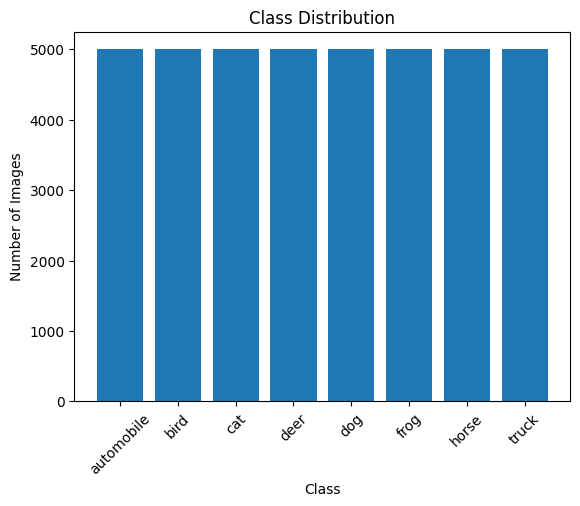

------------------------------------------------------------
TEST SET
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


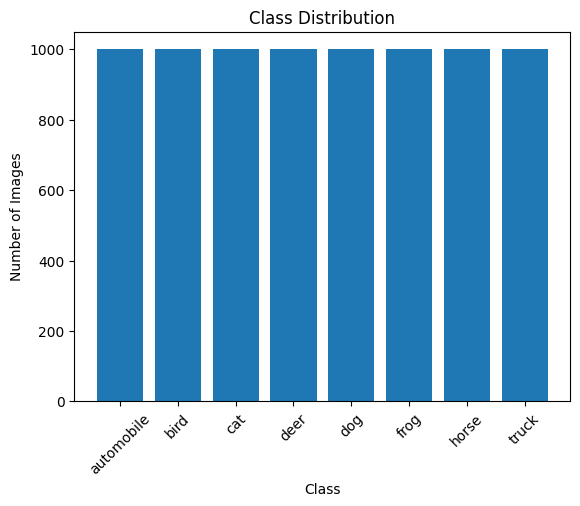

In [ ]:
# Labels
labels = ['automobile','bird', 'cat', 'deer', 'dog', 'frog', 'horse','truck']

print("TRAIN SET")
print(np.unique(y_train, return_counts=True))
class_distribution_plot(y_train, labels)
print("-"*60)
print ("TEST SET")
print(np.unique(y_test, return_counts=True))
class_distribution_plot(y_test, labels)

In [ ]:
def check_corrupted_images(x):
    """
    Print the indices of corrupted images in the dataset.
    """
    corrupted_imgs = []
    for i in range(len(x)):
        img = x[i]
        if np.all(img == 0) or np.all(img == 255):
            corrupted_imgs.append(i)
            print(f"Image {i} could be corrupted.")
    if len(corrupted_imgs) == 0:
        print("No corrupted image found.")

In [ ]:
print("Checking corrupted images in train set...")
check_corrupted_images(x_train)
print("Checking corrupted images in test set...")
check_corrupted_images(x_test)

No corrupted image found.
No corrupted image found.


In [ ]:
def show_random_image(x, y, labels):
  """
  Print a random image with corresponding label from the dataset.
  """
  plt.figure(figsize=(2,2))
  indx = np.random.choice(range(len(x)))
  plt.imshow(x[indx])
  plt.title(labels[y[indx]]);

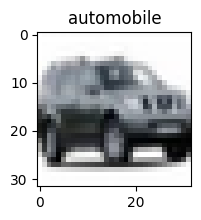

In [ ]:
show_random_image(x_train, y_train, labels)

# Modeling

In [ ]:
x_train, x_test = x_train/255., x_test/255. # Normalization
y_train, y_test = y_train.flatten(), y_test.flatten() # labels linearization

In [ ]:
# model similar to the one previously used in CNN lesson, higher CONV2D values over time
clear_session()

cnn = Sequential([
    InputLayer(input_shape=(32,32,3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax') # 8 classes to predict
])

In [ ]:
optimizer = Adam()
cnn.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics = ['accuracy'])

In [ ]:
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [ ]:
"""
hist = cnn.fit(datagen.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test),
                 epochs = 20, callbacks = [early_stopping])

cnn.save_weights('cnn.weights.h5')
pickle.dump(hist.history, open('cnn_history.pkl', 'wb'))
"""

"\nhist = cnn.fit(datagen.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test),\n                 epochs = 20, callbacks = [early_stopping])\n\ncnn.save_weights('cnn.weights.h5')\npickle.dump(hist.history, open('cnn_history.pkl', 'wb'))\n"

In [ ]:
cnn.load_weights('cnn.weights.h5')
hist = pickle.load(open('cnn_history.pkl', 'rb'))

In [ ]:
cnn.evaluate(x_test, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.7899 - loss: 0.6058


[0.6088957190513611, 0.7908750176429749]

In [ ]:
def plot_history(history):
    """
    Plot the training and validation accuracy and loss.
    """

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history['accuracy'], label = 'accuracy')
    plt.plot(history['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['loss'], label = 'loss')
    plt.plot(history['val_loss'], label = 'val_loss')
    plt.legend();

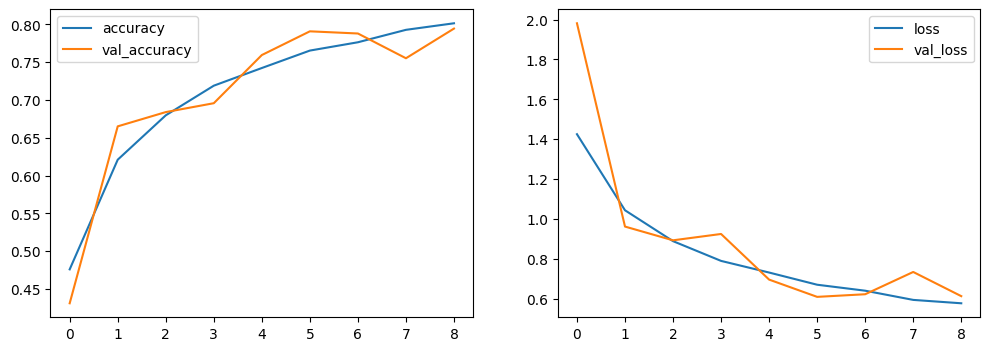

In [ ]:
plot_history(hist)

# Visualization and errors

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Confusion Matrix plotted
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def show_wrong_pred(x, y_true, y_pred, labels):
    """
    Show a random image where model failed to predict.
    """
    wrong_indices = np.where(y_true != y_pred)[0]  # Index Errors
    if len(wrong_indices) == 0:
        print("Model made no error.")
        return

    # Random mistake
    indx = np.random.choice(wrong_indices)

    # View image with predicted label and true label
    plt.figure(figsize=(2, 2))
    plt.imshow(x[indx])
    plt.title(f"Model Predicted: {labels[y_pred[indx]]}\nTrue Label: {labels[y_true[indx]]}")
    plt.show()




250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step


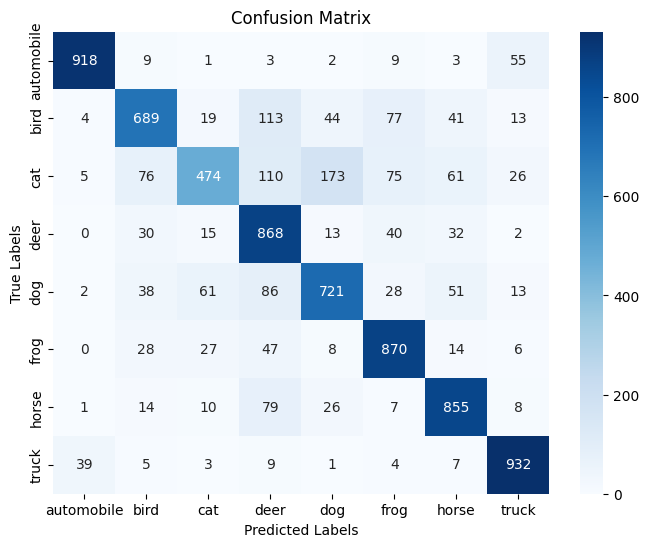

In [ ]:
#Confusion Matrix
y_pred_proba = cnn.predict(x_test)  # Probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Class predicted

plot_confusion_matrix(y_test, y_pred, labels)

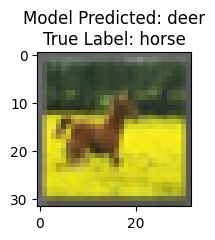

In [ ]:
# Random cnn mistake
show_wrong_pred(x_test, y_test, y_pred, labels)

# Discussion

The initial model appears to perform well, particularly in distinguishing between animals and vehicles. The majority of errors seem to occur in differentiating between cats and dogs, or between cars and trucks, as well as among other animal species.   
There are two potential courses of action moving forward:

- Maintain the current approach, which would require additional data and more advanced models.
- Revise the task to focus only on distinguishing between animals and vehicles in general.

The decision will largely depend on the final objective of the project. To proceed, I will develop a **simpler model** that differentiates between animals and vehicles in general, focusing particularly on larger animals (as smaller ones, such as frogs or birds, are less of an issue in comparison to larger animals like deer or horses), and evaluate its performance.

# Model distinguish between animals and vehicles (CNN2)

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10.load_data()
print(x_train_raw.shape, y_train_raw.shape, x_test_raw.shape, y_test_raw.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


I only need:  
3, 4, 5, 7 (animals) -> 0  
1, 9 (vehicles) -> 1

In [ ]:
wanted_labels = [1, 3, 4, 5, 7, 9]
x_train, y_train, x_test, y_test = filter_labels(x_train_raw, y_train_raw, x_test_raw, y_test_raw, wanted_labels, reset_index=True)

Original training labels: [0 1 2 3 4 5 6 7 8 9]
Original test labels: [0 1 2 3 4 5 6 7 8 9]
Filtered training labels: [0 1 2 3 4 5]
Filtered test labels: [0 1 2 3 4 5]


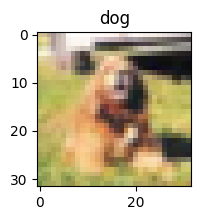

In [ ]:
#check
labels = ['automobile', 'cat', 'deer', 'dog', 'horse','truck']
show_random_image(x_train, y_train, labels)

In [ ]:
# Mapping 0: Animals (dog, cat, horse, deer), 1: Vehicles (car, truck)
y_train = np.where(np.isin(y_train, [0, 5]), 1, 0)
y_test = np.where(np.isin(y_test, [0, 5]), 1, 0)

In [ ]:
print(f"Number of animals images: {len(y_train[y_train == 0])}")
print(f"Number of vehicles images: {len(y_train[y_train == 1])}")

Number of animals images: 20000
Number of vehicles images: 10000


In [ ]:
# Undersampling of Animals Class
# Indexes where y_train == 0
indices_0 = np.where(y_train == 0)[0]

# 10.000 random indexes to remove
indices_0_selected = np.random.choice(indices_0, 10000, replace=False)

# Deleting selected indexes
y_train = np.delete(y_train, indices_0_selected)
x_train = np.delete(x_train, indices_0_selected, axis=0)

In [ ]:
x_train, x_test = x_train/255., x_test/255. # normalization
y_train, y_test = y_train.flatten(), y_test.flatten() # linearization

In [ ]:
# Similar model, but with 2 classes and less neurons in Dense Layer
clear_session()

cnn2 = Sequential([
    InputLayer(input_shape=(32,32,3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.25),
    #
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.25),
    #
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.25),
    #
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # 2 classes to predict
])

In [ ]:
cnn2.compile(optimizer=Adam(learning_rate=1e-4), # lower learning rate
            loss='binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
"""
hist2 = cnn2.fit(x_train, y_train, validation_data=(x_test, y_test),
                 epochs = 20, callbacks = [early_stopping])

cnn2.save_weights('cnn2.weights.h5')
pickle.dump(hist2.history, open('cnn2_history.pkl', 'wb'))
"""

"\nhist2 = cnn2.fit(x_train, y_train, validation_data=(x_test, y_test),\n                 epochs = 20, callbacks = [early_stopping])\n\ncnn2.save_weights('cnn2.weights.h5')\npickle.dump(hist2.history, open('cnn2_history.pkl', 'wb'))\n"

In [ ]:
cnn2.load_weights('cnn2.weights.h5')
hist2 = pickle.load(open('cnn2_history.pkl', 'rb'))

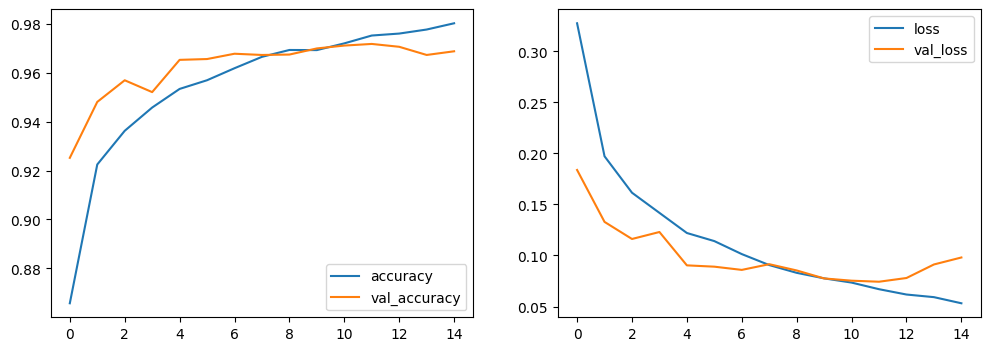

In [ ]:
plot_history(hist2)

188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step


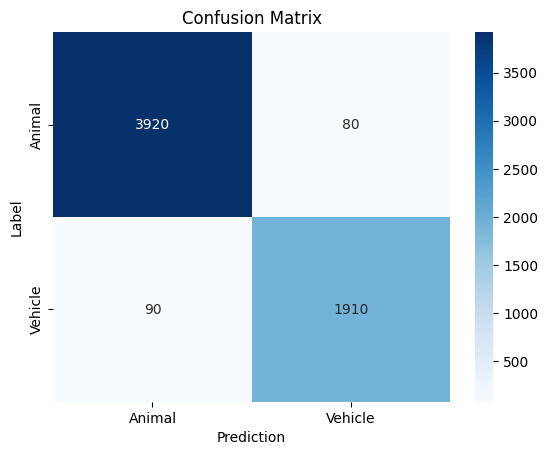

In [ ]:
# Previsioni sul set di test
y_pred = cnn2.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Converti la probabilità in etichetta (0 o 1)

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred_classes)

# Visualizza la matrice di confusione
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Animal', 'Vehicle'], yticklabels=['Animal', 'Vehicle'])
plt.ylabel('Label')
plt.xlabel('Prediction')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
# Classification Report
report = classification_report(y_test, y_pred_classes, target_names=['Animal', 'Vehicle'])
print(report)

              precision    recall  f1-score   support

      Animal       0.98      0.98      0.98      4000
     Vehicle       0.96      0.95      0.96      2000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



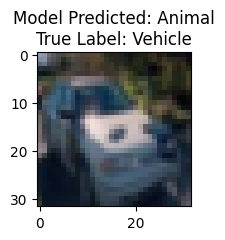

In [ ]:
new_labels = ["Animal","Vehicle"]
y_pred_classes = y_pred_classes.flatten()

show_wrong_pred(x_test, y_test, y_pred_classes, new_labels)

# Future goals
1. **Improve cnn in order to make it viable:**   
Explore Transfer learning strategies or use a bigger dataset

2. **Keep working on cnn2 in order to make it even better:**  
Recall for "Animal" class as higher as possible.
Because model has to alert a driver of the animal presence on the road, and it cannot predict an animal as a vehicle